# グラフ彩色問題

グラフ彩色問題とは、ある制約条件のもとでグラフの要素に色を割り当てる問題です。本チュートリアルでは、隣接する頂点が同じ色にならないように全ての頂点に色を割り当てる問題を通じて、グラフ彩色問題をどのように解くかを説明します。

## 頂点彩色問題とは

以下では、隣接する頂点が同じ色にならないように全ての頂点に色を割り当てる頂点彩色問題を考えます。この頂点彩色問題は、下記の図のように解釈することで四色定理を適用することができ、最大でも4つの色で塗り分けれることがわかります。

![](./assets/graph_coloring_four_color.png)

もし3つの色で頂点が塗り分けられた場合、3-coloringであるといいます。3-coloringで塗り分け可能かどうかを判定する問題はNP完全な問題として有名です。

### 例

例として、6つの頂点を持つ次の無向グラフを考えてみましょう。

![](./assets/graph_coloring_01.png)

このグラフは3-coloringです。なぜなら、以下のように3つの色で頂点を塗り分けることで、辺で隣接する頂点同士が異なる色にできるからです。

![](./assets/graph_coloring_02.png)


### 定式化

上の例を一般化して数理モデルを定式化してみましょう。無向グラフ $G=(V, E)$ を $N$ 色で塗り分けるとします。決定変数 $x_{v, n}$ は、頂点 $v$ が色 $n$ で着彩されている場合に1、そうでない場合に0を取るものとします。

**制約: 各頂点は1色で塗らなければならない**

以下の式は、各頂点 $v$ を1色で塗らなければならないことを意味しています。

$$
\sum_{n=0}^{N-1} x_{v, n} 
= 1 \quad (\forall v \in V) \tag{1}
$$

**目的関数: 両端の頂点が同じ色である辺の個数を最小化する**

$$
\min \quad 
\sum_{n=0}^{N-1} \sum_{(uv) \in E} x_{u, n} x_{v, n} \tag{2}
$$

ここで $E$ はグラフ $G$ に含まれる辺の集合で、$(uv)$ は頂点 $u$ と 頂点 $v$ を両端に持つ辺です。
この目的関数は少々複雑なので、以下の表を参照しながら理解を深めてみましょう。

| $x_{u,n}$ | $x_{v,n}$ | $x_{u,n}x_{v,n}$ |  
|-----------|-----------|------------------|
|     0     |     0     |         0        |
|     0     |     0     |         0        |
|     1     |     0     |         0        |
|     1     |     1     |         1        |

$x_{u, n} u_{v, n}$が1になるには、$x_{u, n}$ と $u_{v, n}$ がともに1である必要があります。 上で定義した通り、$x_{v, n}$ が1になるのは頂点 $v$ が色 $n$ で塗られているときです。そのため、頂点 $u$ と頂点 $v$ が同じ色 $n$ で塗られているときのみ $x_{u, n} u_{v, n}$ が1になります。このことから、この目的関数は、両端の頂点が同じ色の辺があれば増加し、そのような辺がなければ0になることがわかります。つまり、この目的関数は、隣接する頂点が同じ色にならないようにどれだけ塗り分けられたかを示す指標となっています。

## JijModelingによる定式化

次に、JijModelingを使って上記の数理モデルを実装してみましょう。まずは、数理モデルに現れる変数およびパラメーターを定義します。

In [1]:
import jijmodeling as jm

V = jm.Placeholder("V")
E = jm.Placeholder("E", ndim=2)
N = jm.Placeholder("N")
x = jm.BinaryVar("x", shape=(V, N))
n = jm.Element("i", belong_to=(0, N))
v = jm.Element("v", belong_to=(0, V))
e = jm.Element("e", belong_to=E)

ここでは `V` を頂点の数、`E` をグラフ $G$ の辺集合、`N` を色の数として定義しており、$x_{u,v}$ に相当する2次元のバイナリ変数として `x` を定義しています。また、後の数理モデルの構築のために、頂点 $v$ を意味する添字 `v` 、色 $n$ を意味する添字 `n`、辺 $(uv)$ を意味する添字 `e` の定義も行っています。`e[0]` および `e[1]` は辺 $(uv)$ の両端の頂点に相当します。

### 制約条件の実装

制約条件として式(1)を実装すると以下のようになります。

In [2]:
problem = jm.Problem("Graph Coloring")
problem += jm.Constraint("one-color", x[v, :].sum()==1, forall=v)

### 目的関数の実装

次に、目的関数として式(2)を実装すると以下のようになります。

In [3]:
problem += jm.sum([n, e], x[e[0], n]*x[e[1], n])

これで数理モデルの実装は完了です。正しく数理モデルが実装されているかをLaTeX表示を通して確認してみましょう。

In [4]:
problem

## インスタンスデータの準備

数理モデルが実装できたので、次はパラメーターに入力するインスタンスデータを準備します。ここでは、[NetworkX](https://networkx.org/)を使って頂点が12個のグラフをランダム生成するものとします。

In [5]:
import networkx as nx

inst_V = 12
inst_N = 4
inst_G = nx.gnp_random_graph(inst_V, 0.4)
inst_E = [list(edge) for edge in inst_G.edges]
instance_data = {"V": inst_V, "N": inst_N, "E": inst_E}

`inst_V` が頂点の個数、`inst_N` が色の数、`inst_E` が辺集合のインスタンスデータです。

## JijSolverで解く

この問題を`jijsolver`を用いて解きましょう。

In [6]:
import jijsolver

interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)

# 解の可視化

最後に、上記で得られた解を用いてグラフの塗り分けを行ってみましょう。以下のコードで塗り分けられたグラフを見ることができます。

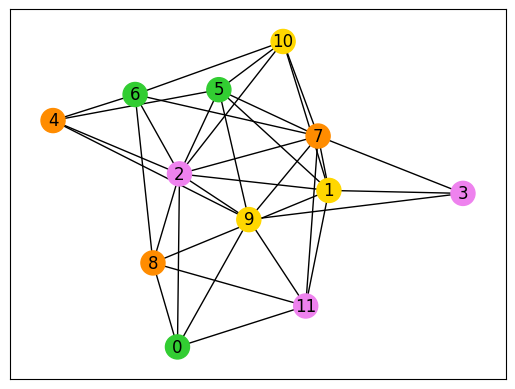

In [7]:
import matplotlib.pyplot as plt

df = solution.decision_variables
indices = df[df["value"] == 1.0]["subscripts"].to_list()
node_colors = [-1] * len(indices)
colorlist = ["gold", "violet", "limegreen", "darkorange"]
for i, j in indices:
    node_colors[i] = colorlist[j]
nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
plt.show()

## 参考資料

[1] [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full)